PyTorch version: 2.1.2
CUDA version: 12.1



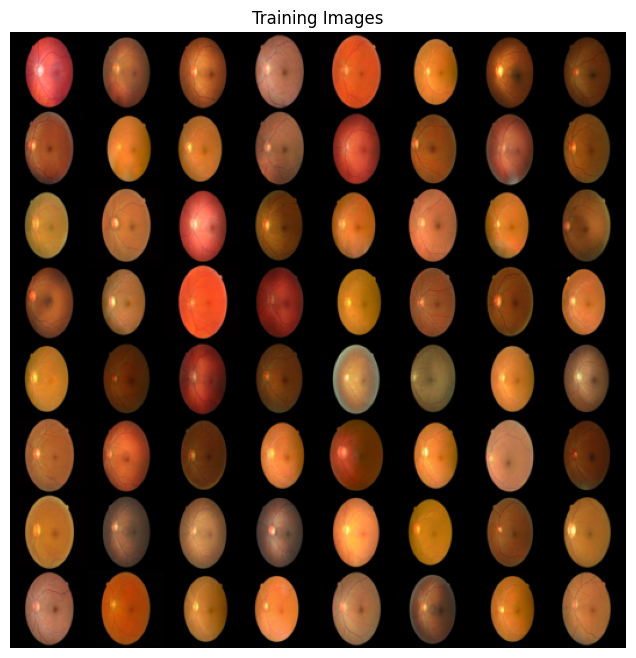

In [13]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable

DATA_PATH = '/kaggle/input/training-data-1024x1024/Test'
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.0002
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

# Data preprocessing
dataset = dset.ImageFolder(root=DATA_PATH,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [14]:
# create Generator and Discriminator
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        #self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x
    
# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

In [15]:
def display_images(img_list):
    # Plot some fake images
    fake_batch = img_list[-1] #next(iter(img_list))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device), nrow=10, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

Starting Training Loop...
[1/5000][0/9]	Loss_D: 1.4755	Loss_G: 2.0082	D(x): 0.5382	D(G(z)): 0.5631 / 0.1406
[2/5000][0/9]	Loss_D: 0.0441	Loss_G: 6.1512	D(x): 0.9870	D(G(z)): 0.0300 / 0.0024
[3/5000][0/9]	Loss_D: 0.0214	Loss_G: 6.7614	D(x): 0.9959	D(G(z)): 0.0171 / 0.0012
[4/5000][0/9]	Loss_D: 0.0130	Loss_G: 7.0443	D(x): 0.9974	D(G(z)): 0.0103 / 0.0009
[5/5000][0/9]	Loss_D: 0.0094	Loss_G: 7.2515	D(x): 0.9978	D(G(z)): 0.0071 / 0.0008
[6/5000][0/9]	Loss_D: 0.0074	Loss_G: 7.3339	D(x): 0.9981	D(G(z)): 0.0054 / 0.0007
[7/5000][0/9]	Loss_D: 0.0077	Loss_G: 7.5357	D(x): 0.9978	D(G(z)): 0.0055 / 0.0006
[8/5000][0/9]	Loss_D: 0.0078	Loss_G: 7.4335	D(x): 0.9982	D(G(z)): 0.0059 / 0.0006
[9/5000][0/9]	Loss_D: 0.0066	Loss_G: 7.5505	D(x): 0.9986	D(G(z)): 0.0052 / 0.0006
[10/5000][0/9]	Loss_D: 0.0067	Loss_G: 7.7388	D(x): 0.9984	D(G(z)): 0.0051 / 0.0005
[11/5000][0/9]	Loss_D: 0.0066	Loss_G: 7.6064	D(x): 0.9975	D(G(z)): 0.0041 / 0.0005
[12/5000][0/9]	Loss_D: 0.0077	Loss_G: 6.2701	D(x): 0.9943	D(G(z)): 0.0

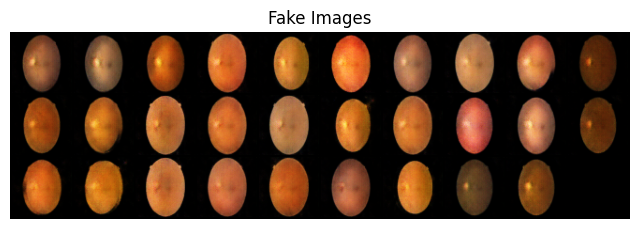

[101/5000][0/9]	Loss_D: 0.6362	Loss_G: 1.3243	D(x): 0.6054	D(G(z)): 0.0821 / 0.3005
[102/5000][0/9]	Loss_D: 0.2661	Loss_G: 2.7112	D(x): 0.8169	D(G(z)): 0.0503 / 0.0864
[103/5000][0/9]	Loss_D: 1.7000	Loss_G: 3.6674	D(x): 0.9765	D(G(z)): 0.7529 / 0.0322
[104/5000][0/9]	Loss_D: 1.7162	Loss_G: 3.8626	D(x): 0.9578	D(G(z)): 0.7776 / 0.0279
[105/5000][0/9]	Loss_D: 0.4315	Loss_G: 1.9598	D(x): 0.7886	D(G(z)): 0.1601 / 0.1655
[106/5000][0/9]	Loss_D: 0.2776	Loss_G: 2.6316	D(x): 0.8842	D(G(z)): 0.1371 / 0.0842
[107/5000][0/9]	Loss_D: 0.2741	Loss_G: 3.5701	D(x): 0.8931	D(G(z)): 0.1417 / 0.0358
[108/5000][0/9]	Loss_D: 0.8749	Loss_G: 1.8829	D(x): 0.7875	D(G(z)): 0.4438 / 0.1687
[109/5000][0/9]	Loss_D: 0.6284	Loss_G: 1.5908	D(x): 0.6812	D(G(z)): 0.1810 / 0.2272
[110/5000][0/9]	Loss_D: 0.6455	Loss_G: 3.2522	D(x): 0.8495	D(G(z)): 0.3545 / 0.0547
[111/5000][0/9]	Loss_D: 0.9747	Loss_G: 3.0502	D(x): 0.9034	D(G(z)): 0.5373 / 0.0553
[112/5000][0/9]	Loss_D: 0.3905	Loss_G: 2.6481	D(x): 0.8260	D(G(z)): 0.1678 /

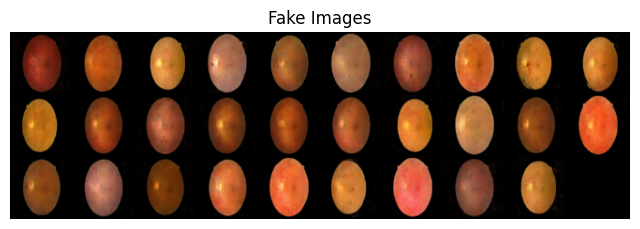

[201/5000][0/9]	Loss_D: 0.1224	Loss_G: 3.9473	D(x): 0.9140	D(G(z)): 0.0271 / 0.0288
[202/5000][0/9]	Loss_D: 0.4129	Loss_G: 3.1258	D(x): 0.7322	D(G(z)): 0.0375 / 0.0821
[203/5000][0/9]	Loss_D: 0.5942	Loss_G: 4.3977	D(x): 0.6321	D(G(z)): 0.0023 / 0.0403
[204/5000][0/9]	Loss_D: 0.8822	Loss_G: 4.2780	D(x): 0.8051	D(G(z)): 0.3665 / 0.1247
[205/5000][0/9]	Loss_D: 0.6874	Loss_G: 5.8826	D(x): 0.9724	D(G(z)): 0.4486 / 0.0046
[206/5000][0/9]	Loss_D: 0.2284	Loss_G: 4.2506	D(x): 0.8637	D(G(z)): 0.0586 / 0.0209
[207/5000][0/9]	Loss_D: 0.0810	Loss_G: 4.6722	D(x): 0.9366	D(G(z)): 0.0142 / 0.0143
[208/5000][0/9]	Loss_D: 0.3960	Loss_G: 3.7390	D(x): 0.6939	D(G(z)): 0.0057 / 0.0374
[209/5000][0/9]	Loss_D: 0.2043	Loss_G: 3.6205	D(x): 0.9781	D(G(z)): 0.1500 / 0.0396
[210/5000][0/9]	Loss_D: 0.1460	Loss_G: 3.4982	D(x): 0.9186	D(G(z)): 0.0518 / 0.0492
[211/5000][0/9]	Loss_D: 2.4550	Loss_G: 2.9487	D(x): 0.8996	D(G(z)): 0.6738 / 0.1254
[212/5000][0/9]	Loss_D: 0.7052	Loss_G: 2.2966	D(x): 0.9545	D(G(z)): 0.4375 /

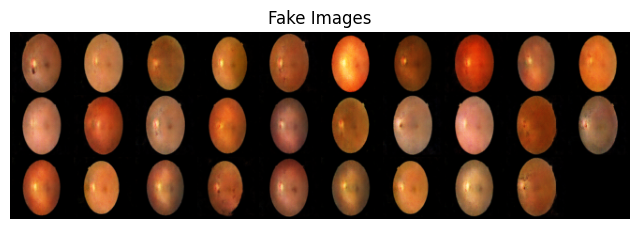

[301/5000][0/9]	Loss_D: 0.1194	Loss_G: 3.9290	D(x): 0.9293	D(G(z)): 0.0422 / 0.0287
[302/5000][0/9]	Loss_D: 0.3387	Loss_G: 4.1853	D(x): 0.8001	D(G(z)): 0.0591 / 0.0527
[303/5000][0/9]	Loss_D: 0.2806	Loss_G: 4.1052	D(x): 0.8936	D(G(z)): 0.0936 / 0.0416
[304/5000][0/9]	Loss_D: 0.2711	Loss_G: 4.5750	D(x): 0.9871	D(G(z)): 0.2120 / 0.0166
[305/5000][0/9]	Loss_D: 0.1372	Loss_G: 3.4796	D(x): 0.9371	D(G(z)): 0.0609 / 0.0446
[306/5000][0/9]	Loss_D: 1.8255	Loss_G: 0.9336	D(x): 0.3959	D(G(z)): 0.1399 / 0.5436
[307/5000][0/9]	Loss_D: 0.2120	Loss_G: 4.0164	D(x): 0.9339	D(G(z)): 0.1286 / 0.0247
[308/5000][0/9]	Loss_D: 0.4767	Loss_G: 4.7561	D(x): 0.9521	D(G(z)): 0.3019 / 0.0164
[309/5000][0/9]	Loss_D: 1.3357	Loss_G: 4.6673	D(x): 0.8360	D(G(z)): 0.5524 / 0.0259
[310/5000][0/9]	Loss_D: 0.5515	Loss_G: 4.1704	D(x): 0.9265	D(G(z)): 0.3477 / 0.0227
[311/5000][0/9]	Loss_D: 0.9958	Loss_G: 3.2027	D(x): 0.8926	D(G(z)): 0.3303 / 0.1014
[312/5000][0/9]	Loss_D: 0.0540	Loss_G: 3.8967	D(x): 0.9781	D(G(z)): 0.0308 /

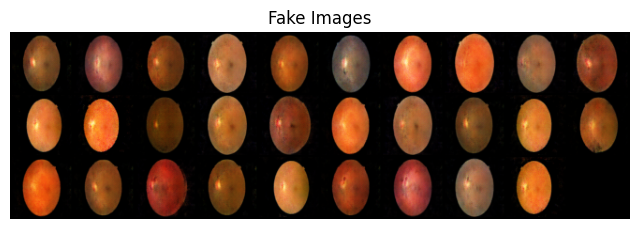

[401/5000][0/9]	Loss_D: 1.1353	Loss_G: 7.5260	D(x): 0.4792	D(G(z)): 0.0026 / 0.0023
[402/5000][0/9]	Loss_D: 1.7801	Loss_G: 0.4834	D(x): 0.2086	D(G(z)): 0.0288 / 0.6607
[403/5000][0/9]	Loss_D: 0.2899	Loss_G: 3.2554	D(x): 0.9547	D(G(z)): 0.1896 / 0.0646
[404/5000][0/9]	Loss_D: 0.4268	Loss_G: 3.0003	D(x): 0.7297	D(G(z)): 0.0515 / 0.1023
[405/5000][0/9]	Loss_D: 3.2340	Loss_G: 6.4013	D(x): 0.1388	D(G(z)): 0.0015 / 0.0031
[406/5000][0/9]	Loss_D: 0.6676	Loss_G: 1.7513	D(x): 0.5708	D(G(z)): 0.0578 / 0.2233
[407/5000][0/9]	Loss_D: 0.8874	Loss_G: 3.5334	D(x): 0.8085	D(G(z)): 0.3256 / 0.0697
[408/5000][0/9]	Loss_D: 0.2994	Loss_G: 3.3679	D(x): 0.9076	D(G(z)): 0.1212 / 0.0742
[409/5000][0/9]	Loss_D: 1.3694	Loss_G: 6.0534	D(x): 0.9707	D(G(z)): 0.6303 / 0.0123
[410/5000][0/9]	Loss_D: 0.3198	Loss_G: 3.0872	D(x): 0.9344	D(G(z)): 0.2106 / 0.0632
[411/5000][0/9]	Loss_D: 0.1209	Loss_G: 3.9043	D(x): 0.9240	D(G(z)): 0.0385 / 0.0340
[412/5000][0/9]	Loss_D: 0.3709	Loss_G: 2.9646	D(x): 0.9739	D(G(z)): 0.2668 /

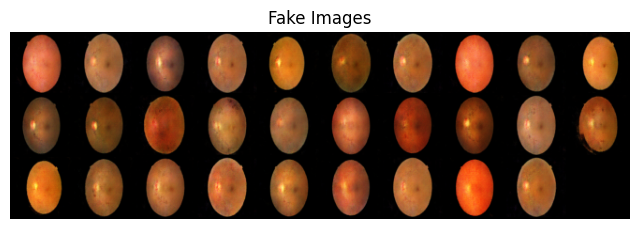

[501/5000][0/9]	Loss_D: 0.2076	Loss_G: 3.1687	D(x): 0.9001	D(G(z)): 0.0854 / 0.0798
[502/5000][0/9]	Loss_D: 2.2403	Loss_G: 3.6451	D(x): 0.9732	D(G(z)): 0.7421 / 0.0720
[503/5000][0/9]	Loss_D: 1.5032	Loss_G: 1.6542	D(x): 0.3332	D(G(z)): 0.0271 / 0.2534
[504/5000][0/9]	Loss_D: 0.2245	Loss_G: 3.7225	D(x): 0.8351	D(G(z)): 0.0343 / 0.0375
[505/5000][0/9]	Loss_D: 0.1719	Loss_G: 3.5139	D(x): 0.8907	D(G(z)): 0.0498 / 0.0628
[506/5000][0/9]	Loss_D: 0.3649	Loss_G: 2.2798	D(x): 0.8187	D(G(z)): 0.0655 / 0.2051
[507/5000][0/9]	Loss_D: 0.3442	Loss_G: 3.5430	D(x): 0.9346	D(G(z)): 0.1868 / 0.0622
[508/5000][0/9]	Loss_D: 0.1579	Loss_G: 3.2111	D(x): 0.9427	D(G(z)): 0.0902 / 0.0533
[509/5000][0/9]	Loss_D: 0.0238	Loss_G: 6.1828	D(x): 0.9794	D(G(z)): 0.0028 / 0.0037
[510/5000][0/9]	Loss_D: 0.2515	Loss_G: 4.5444	D(x): 0.9819	D(G(z)): 0.1966 / 0.0148
[511/5000][0/9]	Loss_D: 0.0651	Loss_G: 4.2221	D(x): 0.9724	D(G(z)): 0.0343 / 0.0294
[512/5000][0/9]	Loss_D: 0.0665	Loss_G: 4.5129	D(x): 0.9510	D(G(z)): 0.0150 /

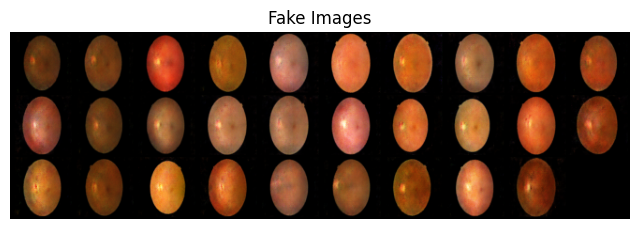

[601/5000][0/9]	Loss_D: 0.0702	Loss_G: 4.0256	D(x): 0.9571	D(G(z)): 0.0255 / 0.0256
[602/5000][0/9]	Loss_D: 0.0290	Loss_G: 5.7786	D(x): 0.9778	D(G(z)): 0.0060 / 0.0136
[603/5000][0/9]	Loss_D: 1.9230	Loss_G: 3.1118	D(x): 0.4147	D(G(z)): 0.0117 / 0.1286
[604/5000][0/9]	Loss_D: 0.3593	Loss_G: 3.4442	D(x): 0.7750	D(G(z)): 0.0326 / 0.0502
[605/5000][0/9]	Loss_D: 0.0279	Loss_G: 5.9119	D(x): 0.9765	D(G(z)): 0.0040 / 0.0048
[606/5000][0/9]	Loss_D: 0.0228	Loss_G: 5.2912	D(x): 0.9891	D(G(z)): 0.0116 / 0.0083
[607/5000][0/9]	Loss_D: 0.9108	Loss_G: 3.1456	D(x): 0.5766	D(G(z)): 0.0494 / 0.1255
[608/5000][0/9]	Loss_D: 0.1496	Loss_G: 5.7041	D(x): 0.9137	D(G(z)): 0.0097 / 0.0482
[609/5000][0/9]	Loss_D: 0.2066	Loss_G: 4.3157	D(x): 0.8269	D(G(z)): 0.0087 / 0.0264
[610/5000][0/9]	Loss_D: 0.0784	Loss_G: 3.7918	D(x): 0.9599	D(G(z)): 0.0358 / 0.0352
[611/5000][0/9]	Loss_D: 1.5136	Loss_G: 6.0077	D(x): 0.3294	D(G(z)): 0.0008 / 0.0184
[612/5000][0/9]	Loss_D: 4.3756	Loss_G: 3.5968	D(x): 0.0222	D(G(z)): 0.0003 /

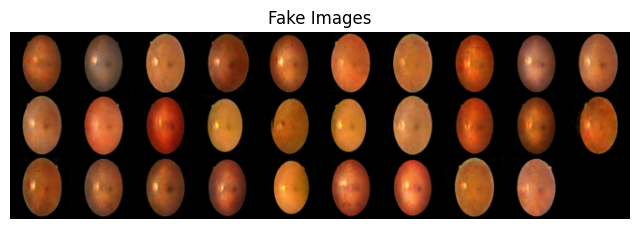

[701/5000][0/9]	Loss_D: 0.3514	Loss_G: 5.1399	D(x): 0.9949	D(G(z)): 0.2757 / 0.0102
[702/5000][0/9]	Loss_D: 0.1382	Loss_G: 4.8097	D(x): 0.8916	D(G(z)): 0.0152 / 0.0136
[703/5000][0/9]	Loss_D: 0.0189	Loss_G: 5.2659	D(x): 0.9919	D(G(z)): 0.0107 / 0.0114
[704/5000][0/9]	Loss_D: 3.8218	Loss_G: 7.8136	D(x): 0.1843	D(G(z)): 0.0009 / 0.0031
[705/5000][0/9]	Loss_D: 0.8698	Loss_G: 2.9608	D(x): 0.5504	D(G(z)): 0.0338 / 0.1127
[706/5000][0/9]	Loss_D: 1.4610	Loss_G: 3.8389	D(x): 0.3053	D(G(z)): 0.0049 / 0.0509
[707/5000][0/9]	Loss_D: 0.2467	Loss_G: 4.0518	D(x): 0.9831	D(G(z)): 0.1933 / 0.0271
[708/5000][0/9]	Loss_D: 0.1913	Loss_G: 3.8136	D(x): 0.9868	D(G(z)): 0.1535 / 0.0292
[709/5000][0/9]	Loss_D: 0.1126	Loss_G: 6.7285	D(x): 0.8988	D(G(z)): 0.0019 / 0.0025
[710/5000][0/9]	Loss_D: 0.0324	Loss_G: 5.0025	D(x): 0.9847	D(G(z)): 0.0165 / 0.0131
[711/5000][0/9]	Loss_D: 1.1693	Loss_G: 5.1342	D(x): 0.3577	D(G(z)): 0.0012 / 0.0119
[712/5000][0/9]	Loss_D: 0.1118	Loss_G: 3.8609	D(x): 0.9961	D(G(z)): 0.0958 /

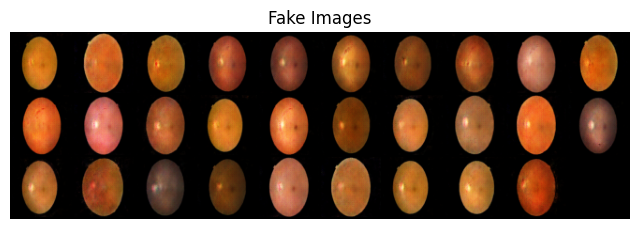

[801/5000][0/9]	Loss_D: 3.7952	Loss_G: 1.9121	D(x): 0.1015	D(G(z)): 0.0078 / 0.4846
[802/5000][0/9]	Loss_D: 0.5743	Loss_G: 3.2134	D(x): 0.6775	D(G(z)): 0.0634 / 0.0625
[803/5000][0/9]	Loss_D: 0.0577	Loss_G: 4.0234	D(x): 0.9747	D(G(z)): 0.0309 / 0.0342
[804/5000][0/9]	Loss_D: 0.6976	Loss_G: 2.2882	D(x): 0.7727	D(G(z)): 0.0792 / 0.2395
[805/5000][0/9]	Loss_D: 0.0366	Loss_G: 4.5430	D(x): 0.9853	D(G(z)): 0.0212 / 0.0187
[806/5000][0/9]	Loss_D: 0.4419	Loss_G: 3.5298	D(x): 0.7697	D(G(z)): 0.0318 / 0.0655
[807/5000][0/9]	Loss_D: 0.3293	Loss_G: 5.0803	D(x): 0.8583	D(G(z)): 0.0552 / 0.0376
[808/5000][0/9]	Loss_D: 0.5328	Loss_G: 4.6318	D(x): 0.9939	D(G(z)): 0.3365 / 0.0264
[809/5000][0/9]	Loss_D: 0.1088	Loss_G: 3.8339	D(x): 0.9921	D(G(z)): 0.0930 / 0.0310
[810/5000][0/9]	Loss_D: 0.0319	Loss_G: 4.9094	D(x): 0.9852	D(G(z)): 0.0167 / 0.0131
[811/5000][0/9]	Loss_D: 0.4773	Loss_G: 4.3885	D(x): 0.7646	D(G(z)): 0.0810 / 0.1115
[812/5000][0/9]	Loss_D: 0.0601	Loss_G: 4.1265	D(x): 0.9932	D(G(z)): 0.0508 /

In [ ]:
# Training
    
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
good_Training=False
#noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-2000/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/weights128-2000/discriminator.weight'))#,map_location=torch.device('cpu')
    
    #netG.load_state_dict(torch.load('/kaggle/input/weights-64-9000/generator.weight'))
    #netD.load_state_dict(torch.load('/kaggle/input/weights-64-9000/discriminator.weight'))
    
    #netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))
    #netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))

    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(dataloader, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            # Generate batch of latent vectors
            noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 9 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=25 or avg_D_Loss>=5 or avg_D_Loss==0:
                print('Exited')
                break
        
        if ((epoch+1)%100==0):
            print("........Saving.......")
            %mkdir /kaggle/working/{epoch+1}
            torch.save(netG.state_dict(), f'/kaggle/working/{epoch+1}/generator.weight')
            torch.save(netD.state_dict(), f'/kaggle/working/{epoch+1}/discriminator.weight')
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(fake)
            display_images(img_list)


In [ ]:
#plot loss graph

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Generate image
%mkdir /kaggle/working/Generated_Batch
def save_image(fake):
    print('Generated Image Size: ',fake[0].shape)
    for i,genrated_image in enumerate(fake):
        #print(i)
        genrated_image = np.moveaxis(genrated_image, 0, -1)
        #print(genrated_image.shape)
        m = np.min(genrated_image)
        M = np.max(genrated_image)
        genrated_image = (genrated_image-m)/(M-m)
        genrated_image = 255*genrated_image
        genrated_image = np.array(genrated_image, dtype='uint8')
        #plt.imshow(genrated_image)
        #plt.show()
        plt.imsave(f'/kaggle/working/Generated_Batch/{i}.png', genrated_image)

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data.shape)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[:64],nrow=8, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

if __name__=='__main__':
    c=0
    #netG = generator()
    netG.to(device)
    netG.load_state_dict(torch.load('/kaggle/input/weights-64-9000/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/working/200/generator.weight'))
    #netG.load_state_dict(torch.load('/kaggle/input/weights128-3000/generator.weight'))
    

    noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    with torch.no_grad():
        #print(noise.shape)
        fake = netG(noise)#.detach().cpu()#.numpy()
    
    #save_image(netG(noise).detach().cpu().numpy())
        
    display_image(fake,'Fake')

    #display_image(img_list[-2],'Fake')
    #display_image(img_list[-1],'Fake')


In [ ]:
import shutil

source_folder = '/kaggle/working/Generated_Batch'
output_path = '/kaggle/working/'

shutil.make_archive('Output', 'zip', source_folder)

In [ ]:
#%lsmagic
#%rm -rf /kaggle/working/*
#%tar -cf outputs.tar /kaggle/working/Generated_Batch
#%apt update && sudo apt install zip